In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import healpy as hp
import urllib.request
import os
import matplotlib.pyplot as plt

/global/homes/c/cdavies/miniconda3/envs/hos/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


This notebook provides some code and a tutorial for jackknifing a full sky convergence map, which can be used to estimate error bars for statistics that are computed on the convergence map.

In [2]:
#here we define some functions
def get_takahashi(url, output_directory, output_filename):
    """
    Downloads and processes the a Takahashi kappa map data file, saving the processed data as a .fits file.

    Parameters
    ----------
    url : str
        The URL to download the Takahashi data file from.
    output_directory : str
        The directory where the downloaded and processed files will be saved.
    output_filename : str
        The name of the file to save the downloaded data as (without the .fits extension).

    Notes
    -----
    This function downloads the file from the specified URL if it does not already exist in the output directory.
    It then reads and processes the file, extracting specific data blocks and saving them into a .fits file.
    """
    
    download_path = f'{output_directory}/{output_filename}'
    if not os.path.exists(download_path):
        urllib.request.urlretrieve(url, download_path)

    filename = f'{output_directory}/{output_filename}'
    save_path = f'{output_directory}/{output_filename}.fits'
    
    if not os.path.exists(save_path):
        skip = [0, 536870908, 1073741818, 1610612728, 2147483638, 2684354547, 3221225457]
        load_blocks = [skip[i+1]-skip[i] for i in range(0, 6)]

        with open(filename, 'rb') as f:
            rec = np.fromfile(f, dtype='uint32', count=1)[0]
            nside = np.fromfile(f, dtype='int32', count=1)[0]
            npix = np.fromfile(f, dtype='int64', count=1)[0]
            rec = np.fromfile(f, dtype='uint32', count=1)[0]
            print("nside:{} npix:{}".format(nside, npix))

            rec = np.fromfile(f, dtype='uint32', count=1)[0]

            kappa = np.array([])
            r = npix
            for i, l in enumerate(load_blocks):
                blocks = min(l, r)
                load = np.fromfile(f, dtype='float32', count=blocks)
                np.fromfile(f, dtype='uint32', count=2)
                kappa = np.append(kappa, load)
                r = r-blocks
                if r == 0:
                    break
                elif r > 0 and i == len(load_blocks)-1:
                    load = np.fromfile(f, dtype='float32', count=r)
                    np.fromfile(f, dtype='uint32', count=2)
                    kappa = np.append(kappa, load)
        
        hp.fitsfunc.write_map(save_path, kappa)
        
        
def get_patches(npix, nside_patch):
    """
    Generates a mapping from pixels to patches based on HEALPix grid resolution.

    Parameters
    ----------
    npix : int
        The total number of pixels in the original map (at the original nside).
    nside_patch : int
        The nside resolution of the patches.

    Returns
    -------
    ith_pixel_patch : ndarray
        An array where each element indicates the patch index that the corresponding pixel belongs to.
    """
    
    ith_pixel = np.arange(npix)
    npatch = hp.nside2npix(nside_patch)
    ith_patch = np.arange(npatch)
    ith_pixel_angle = hp.pix2ang(hp.npix2nside(npix),ith_pixel)
    ith_pixel_patch = hp.ang2pix(nside_patch,ith_pixel_angle[0],ith_pixel_angle[1])
    
    return ith_pixel_patch


def jackknife_map(kappa, ith_pixel_patch, i):
    """
    Creates a jackknife resampled map by masking out one patch.

    Parameters
    ----------
    kappa : ndarray
        The original data map.
    ith_pixel_patch : ndarray
        An array mapping each pixel to its corresponding patch.
    i : int
        The index of the patch to mask out.

    Returns
    -------
    kappa : ndarray
        The jackknife resampled map, where the selected patch is masked out with `hp.UNSEEN`.
    """
    
    kappa = np.copy(kappa)
    jackknife_filter = ith_pixel_patch == i
    kappa[jackknife_filter] = hp.UNSEEN
    
    return kappa


def get_bins(lower, upper, nbins, return_edges = False):

    binEdges = np.linspace(lower, upper, nbins + 1 ) 
    binMid = ( binEdges[1:] + binEdges[:-1] ) / 2.

    if return_edges:
        return binMid, binEdges
    else:
        return binMid
    
    
    
def find_extrema_jackknife(kappa_map, nside_patch, minima=False, lonlat=False):
    """find extrema in a smoothed masked healpix map
       default is to find peaks, finds minima with minima=True
    
       Parameters
       ----------
       kappa_masked_smooth: MaskedArray (healpy object)
           smoothed masked healpix map for which extrema are to be identified
       minima: bool
           if False, find peaks. if True, find minima
       
       Returns
       -------
       extrema_pos: np.ndarray
           extrema positions on sphere, theta and phi, in radians
       extrema_amp: np.ndarray
           extrema amplitudes in kappa
       
    """

    #first create an array of all neighbours for all valid healsparse pixels
    nside = hp.get_nside(kappa_map) #get nside
    npix_full = hp.nside2npix(nside)
    ipix_full = np.arange(npix_full)
    
    if type(kappa_map.mask) is np.bool_:
        ipix = np.arange(npix_full) #list all pixels and remove masked ones
    if type(kappa_map.mask) is np.ndarray:
        ipix = np.arange(npix_full)[~kappa_map.mask]
        
    neighbours = hp.get_all_neighbours(nside, ipix) #find neighbours for all pixels we care about
    
    #get kappa values for each pixel in the neighbour array
    neighbour_vals = kappa_map.data[neighbours.T]
    #get kappa values for all valid healsparse pixels
    pixel_val = kappa_map.data[ipix]

    #compare all valid healsparse pixels with their neighbours to find extrema
    if minima:
        extrema = np.all(np.tile(pixel_val,[8,1]).T < neighbour_vals,axis=-1)
    else:
        extrema = np.all(np.tile(pixel_val,[8,1]).T > neighbour_vals,axis=-1)
    
    #extrema needs to be the same shape as a full sky map (no mask) to be compatible with get_patches
    use_extrema_full = False
    if len(ipix) < npix_full:
        extrema_full = np.zeros(npix_full).astype(bool)
        extrema_full[ipix] = extrema
        use_extrema_full = True
        
    #print the number of extrema identified
    if minima:
        print(f'number of minima identified: {np.where(extrema)[0].shape[0]}')
    else:
        print(f'number of peaks identified: {np.where(extrema)[0].shape[0]}')

    #print(ipix.shape, extrema.shape)
    extrema_pos = np.asarray(hp.pix2ang(nside, ipix[extrema],lonlat=lonlat)).T #find the extrema positions
    extrema_amp = kappa_map[ipix][extrema].data #find the extrema amplitudes
    
    #some additional code to perform the jackknifing of the extrema
    ith_pixel_patch = get_patches(npix, nside_patch)
    n_patch = hp.nside2npix(nside_patch)
    extrema_pos_jackknife = []
    extrema_amp_jackknife = []
    for i in range(n_patch):
        if use_extrema_full:
            extrema_jackknife = np.copy(extrema_full)
        if not use_extrema_full:
            extrema_jackknife = np.copy(extrema)
        jackknife_filter = ith_pixel_patch == i
        extrema_jackknife[jackknife_filter] = 0

        extrema_pos_jackknife.append( np.asarray(hp.pix2ang(nside, ipix_full[extrema_jackknife],lonlat=lonlat)).T )#find the extrema positions
        extrema_amp_jackknife.append( kappa_map[ipix_full][extrema_jackknife].data ) #find the extrema amplitudes
        
    return extrema_pos, extrema_amp, extrema_pos_jackknife, extrema_amp_jackknife

In [3]:
#download a T17 map and convert to fits file
url = 'http://cosmo.phys.hirosaki-u.ac.jp/takahasi/allsky_raytracing/sub1/nres12/allskymap_nres12r000.zs16.mag.dat'
output_directory = '/pscratch/sd/c/cdavies/data/takahashi/'
output_filename = 'allskymap_nres12r000.zs16.mag.dat'
#change the above strings to suit your needs

get_takahashi(url, output_directory, output_filename)

In [4]:
#load T17 map and downgrade resolution for speed
nside_out = 1024
kappa_high_res = hp.read_map(f'{output_directory}/{output_filename}.fits')
kappa = hp.ud_grade(kappa_high_res,nside_out=nside_out)
kappa = hp.ma(kappa)

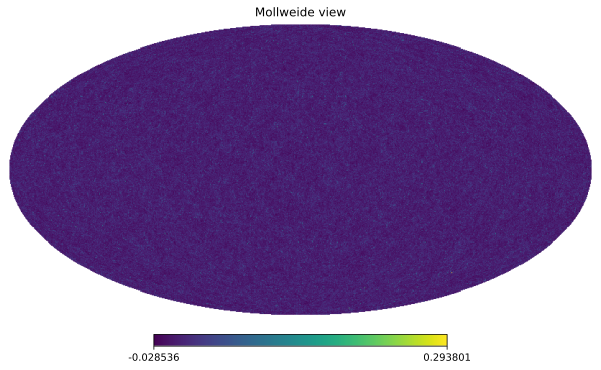

In [5]:
hp.mollview(kappa)

The following code allows us to remove patches from an input kappa map (a Takahashi map in this case). This patch is then moved across the sky to generate a full jackknife sample

In [6]:
npix = len(kappa)
nside_patch = 4
print(f'generating {hp.nside2npix(nside_patch)} jackknife samples')

ith_pixel_patch = get_patches(npix, nside_patch)

generating 192 jackknife samples


Here we are plotting an illustration of the different patches that are removed throughout the jackknife sample

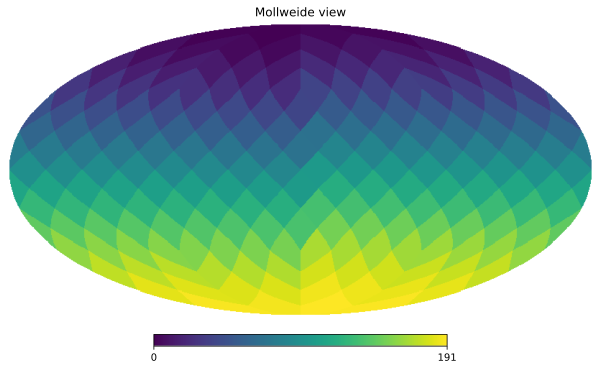

In [7]:
hp.mollview(ith_pixel_patch)

Now we perform the jackknifing on the convergence map, by looping over all patches. Note that the function implemented here does this for one patch at a time within the for loop, allowing for easy modification to save memory. 

In [8]:
npatch = hp.nside2npix(nside_patch)
kappa_jackknife_array = np.zeros([npatch, npix])
for i in range(npatch):
    kappa_jackknife_array[i] = jackknife_map(kappa, ith_pixel_patch, i)

Now we can plot a subset of the jackknife samples to see how the patches of the sky have been removed from the data

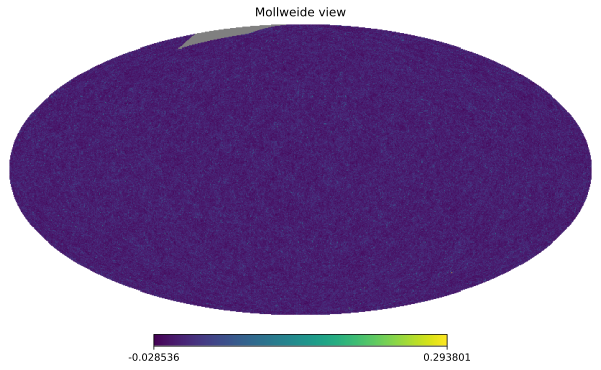

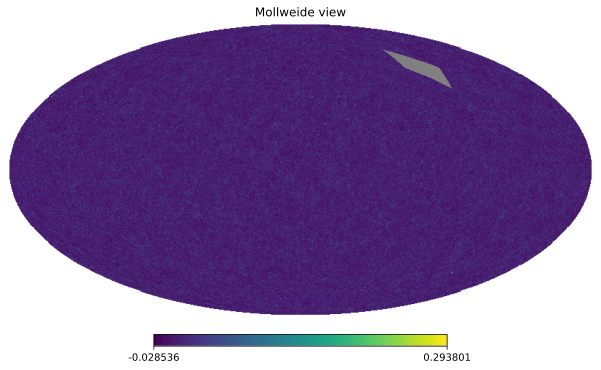

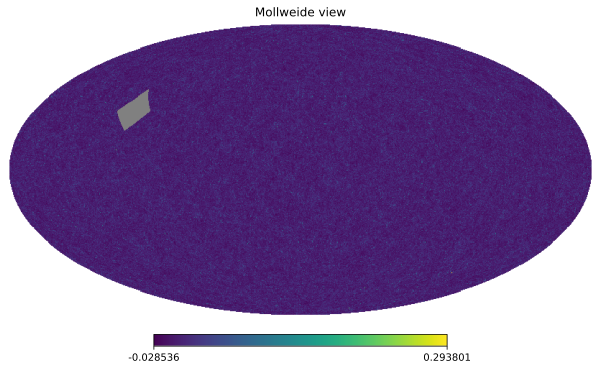

In [9]:
for example in [1,20,45]:
    hp.mollview(kappa_jackknife_array[example])

In [10]:
print(kappa_jackknife_array.shape)

(192, 12582912)


In [11]:
#set pdf bins
lower = -0.03
upper = 0.2
nbins = 50
binMid,binEdges = get_bins(lower, upper, nbins, return_edges =True)


PDF, _ = np.histogram(kappa, binEdges)
PDF_jackknife = np.zeros([npatch, nbins])
for i in range(npatch):
    PDF_jackknife[i], _ = np.histogram(kappa_jackknife_array[i], binEdges)

PDF_standard_error = np.std(PDF_jackknife,axis=0)
PDF_standard_deviation = np.std(PDF_jackknife,axis=0) * npatch

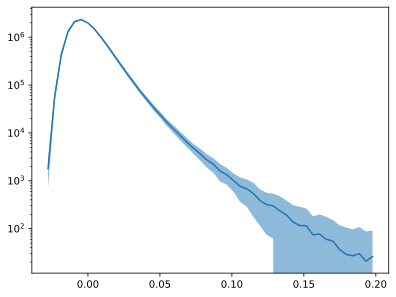

In [12]:
plt.plot(binMid, PDF)
plt.fill_between(binMid, PDF - PDF_standard_deviation, PDF + PDF_standard_deviation, alpha=0.5)
plt.semilogy()
plt.show()

In [13]:
extrema_pos, extrema_amp, extrema_pos_jackknife, extrema_amp_jackknife = find_extrema_jackknife(kappa, nside_patch)

number of peaks identified: 1043995


In [14]:
#set peak abundance bins
lower = -0.01
upper = 0.1
nbins = 50
binMid,binEdges = get_bins(lower, upper, nbins, return_edges =True)


peak_abundance, _ = np.histogram(extrema_amp, binEdges)
peak_abundance_jackknife = np.zeros([npatch, nbins])
for i in range(npatch):
    peak_abundance_jackknife[i], _ = np.histogram(extrema_amp_jackknife[i], binEdges)
    
peak_abundance_standard_error = np.std(peak_abundance_jackknife,axis=0)
peak_abundance_standard_deviation = np.std(peak_abundance_jackknife,axis=0) * npatch

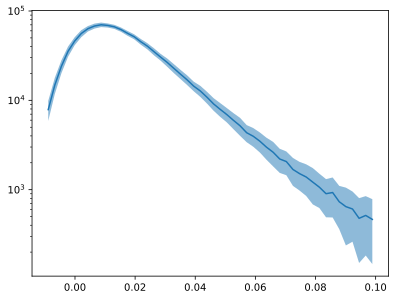

In [15]:
plt.plot(binMid, peak_abundance)
plt.fill_between(binMid, peak_abundance - peak_abundance_standard_deviation, peak_abundance + peak_abundance_standard_deviation, alpha=0.5)
plt.semilogy()
plt.show()

In [17]:
base_dir = '/global/cfs/cdirs/lsst/groups/WL/projects/wl-massmap/IA-infusion/SkySim5000'
kappa_octant_dir = f'{base_dir}/kappa/nz_SRD_KS/NLA/kappa_skysim5000_noIA_noisy_tomo1.dat.npy'
mask_dir = f'{base_dir}/FullSky_weight.fits'


kappa_octant_high_res = np.load(kappa_octant_dir)
kappa_octant = hp.ud_grade(kappa_octant_high_res,nside_out=nside_out)

mask_high_res = hp.fitsfunc.read_map(mask_dir, field=0, nest=False, partial=False, 
                            hdu=1, h=False, verbose=True, memmap=True)
mask = hp.ud_grade(mask_high_res,nside_out=nside_out).astype(bool)

kappa_octant[~mask] = hp.UNSEEN
kappa_octant = hp.ma(kappa_octant)

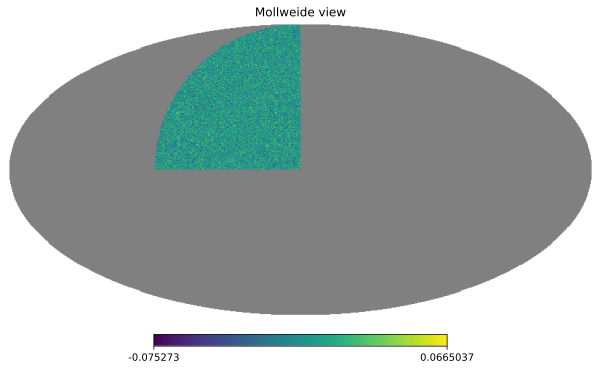

In [18]:
hp.mollview(kappa_octant)

In [19]:
kappa_octant_jackknife_array = np.zeros([npatch, npix])
for i in range(npatch):
    kappa_octant_jackknife_array[i] = jackknife_map(kappa_octant, ith_pixel_patch, i)
    
good_jackknife = np.zeros([npatch],dtype=bool)
for i in range(npatch):
    good_jackknife[i] = np.any(kappa_octant_jackknife_array[i][mask] != kappa_octant[mask] )

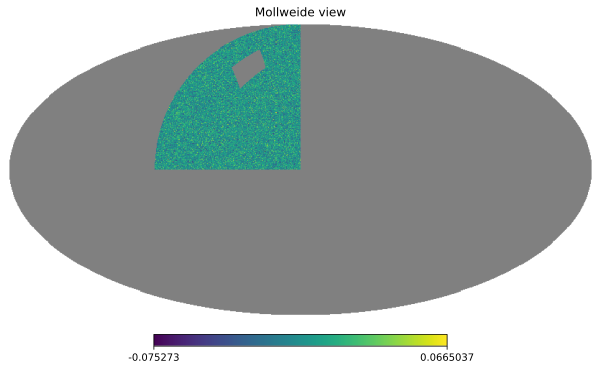

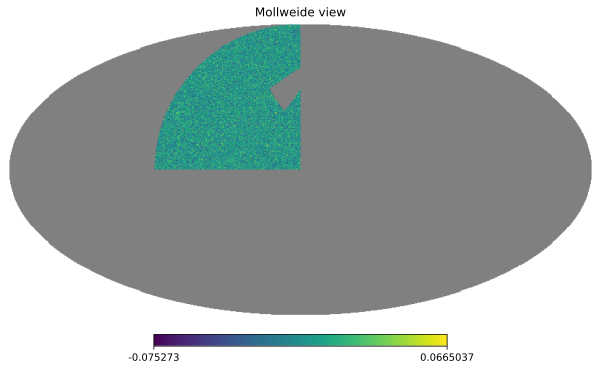

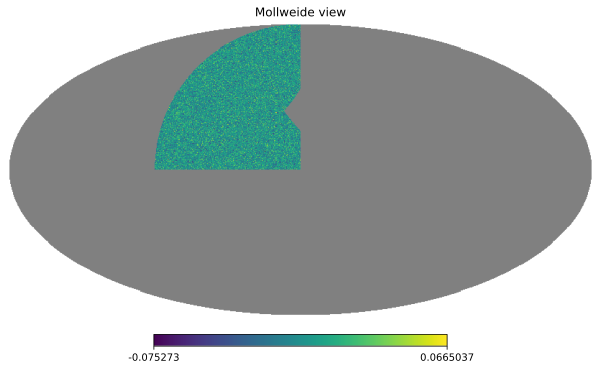

In [20]:
for example in [4,6,10]:
    hp.mollview(kappa_octant_jackknife_array[good_jackknife][example])

In [21]:
#set pdf bins
lower = -0.03
upper = 0.06
nbins = 50
binMid,binEdges = get_bins(lower, upper, nbins, return_edges =True)

PDF, _ = np.histogram(kappa_octant, binEdges)
PDF_jackknife = np.zeros([npatch, nbins])
for i in range(npatch):
    PDF_jackknife[i], _ = np.histogram(kappa_octant_jackknife_array[i], binEdges)

PDF_standard_error = np.std(PDF_jackknife,axis=0)
PDF_standard_deviation = np.std(PDF_jackknife,axis=0) * good_jackknife.sum()

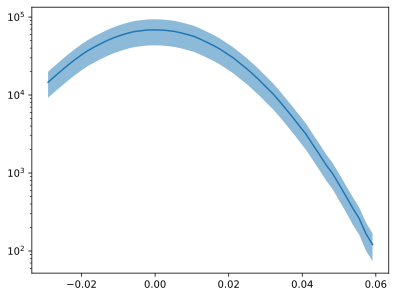

In [22]:
plt.plot(binMid, PDF)
plt.fill_between(binMid, PDF - PDF_standard_deviation, PDF + PDF_standard_deviation, alpha=0.5)
plt.semilogy()
plt.show()

In [23]:
extrema_pos, extrema_amp, extrema_pos_jackknife, extrema_amp_jackknife = find_extrema_jackknife(kappa_octant, nside_patch)

number of peaks identified: 106774


In [24]:
#set peak abundance bins
lower = -0.01
upper = 0.05
nbins = 50
binMid,binEdges = get_bins(lower, upper, nbins, return_edges =True)

good_jackknife = np.zeros([npatch],dtype=bool)
for i in range(npatch):
    good_jackknife[i] = len(extrema_amp_jackknife[i]) != len(extrema_amp)
    
extrema_pos_jackknife_good = []
extrema_amp_jackknife_good = []
for i, i_bool in enumerate(good_jackknife):
    if i_bool:
        extrema_pos_jackknife_good.append(extrema_pos_jackknife[i])
        extrema_amp_jackknife_good.append(extrema_amp_jackknife[i])

peak_abundance, _ = np.histogram(extrema_amp, binEdges)
peak_abundance_jackknife = np.zeros([npatch, nbins])
for i in range(good_jackknife.sum()):
    peak_abundance_jackknife[i], _ = np.histogram(extrema_amp_jackknife_good[i], binEdges)
    
peak_abundance_standard_error = np.std(peak_abundance_jackknife,axis=0)
peak_abundance_standard_deviation = np.std(peak_abundance_jackknife,axis=0) * np.sum(good_jackknife)

In [25]:
extrema_pos_jackknife_good = []
extrema_amp_jackknife_good = []
for i, i_bool in enumerate(good_jackknife):
    if i_bool:
        extrema_pos_jackknife_good.append(extrema_pos_jackknife[i])
        extrema_amp_jackknife_good.append(extrema_amp_jackknife[i])

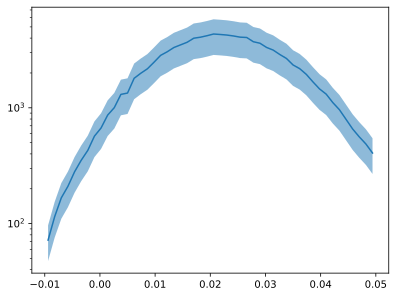

In [26]:
plt.plot(binMid, peak_abundance)
plt.fill_between(binMid, peak_abundance - peak_abundance_standard_error, peak_abundance + peak_abundance_standard_error, alpha=0.5)
plt.semilogy()
plt.show()